# *Vanilla* Transformer from scrach with JAX/Flax

 This is a first notebook of a tutorial to understand implementation of Transformer Models with JAX/Flax. As a first step, this notebook shows how to implement *Vanilla* Transformer. Vanilla Transformer aka Transformer Encoder Decoder Model, was originally introduced in "Attention is all you need"[1] and is the origin of all derived transformers. Let's understand Transformer and how to use JAX/Flax!

The main contents are the following.

1. Implement *Vanilla* Transformer from scratch.

1. Using the Multi30k dataset, train the transformer to translate German to English.

1. Translate some sentences with a greedy search translator.

1. Plot attention matrices.

The key features of this implementation are the following.

1. Implement *Vanilla* Transformer with the original class of MultiHeadAttention and PositionalEncoder.

1. Made a translator that can translate batch by batch, not sentence by sentence.

1. By padding, all source/target sentences to max sequence length, fix an input shape of the jit compiled function and minimize the number of compile. That enabled it to accelerate training very much!

1. Usually, query and key sequences are masked simultaneously and masked positions are changed to `jnp.finfo(dtype).min` in attention calculation with JAX/Flax implementation. In this implementation, only key sequences are masked, masked positions are changed to `-jnp.inf`, and query sequences are masked in a loss function as common implementations.

The points that can be added in the future are the following.

1. Use sentence piece tokenizer instead of SpaCy tokenizer.

1. Implement a beam search tokenizer from scratch.

1. Implement a function that calculates BLEU score from scratch.


## Check GPU Settings
　Check the GPU settings; with Colab, the GPU is not always the same, so it's good to check each time what's assigned. In this case, it was Tesla T4. Also, it is necessary to check the version of CUDA and Driver when installing JAX and Flax.

In [ ]:
!nvidia-smi

Fri Feb 24 09:17:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


# Install and Import Libraries
　Install jax, flax, optax and import the necessary libraries.

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q flax==0.6.1 optax==0.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Using cached https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.4%2Bcuda11.cudnn86-cp38-cp38-manylinux2014_x86_64.whl (156.8 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.4+cuda11.cudnn82
    Uninstalling jaxlib-0.4.4+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.4.4+cuda11.cudnn82
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Using cached https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.4%2Bcuda11.cudnn82-cp38-cp38-manylinux2014_x86_64.whl (154.5 MB)
  Attempting uninstall: jaxlib
    Found existing in

In [ ]:
import os
import re
from typing import Dict, Optional, List, Union, Callable, Any, Tuple
import time, datetime
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import jax, optax
from jax import random, numpy as jnp
import jax.lax as lax
import numpy as np

from flax import linen as nn
from flax import jax_utils
from flax.training import train_state, checkpoints
from flax.training import common_utils

## Prepare Multi30k Datasets
　For simplicity, we will use a Multi30k dataset from torchtext and SpaCy for the tokenizer. These are also used in Pytorch's tutorials, so you may want to compare with them. (Officially, TensorFlow Datasets are recommended.)

In [ ]:
!pip install -U spacy
!pip install torch torchvision torchtext==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
try:
  from torchtext.datasets import Multi30k
except OSError:
  from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import spacy.cli 
spacy.cli.download('en_core_web_sm')
spacy.cli.download('de_core_news_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


Using SpaCy, define German and English tokenize functions, source (German and target (English) fields. Then, the dataset is divided and iterators are created for training, validation, and testing. The batch size is 128. Finally, create functions to convert from a list of tokens (type str) to a list of IDs (type int) and vice versa, for German and English, respectively.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text: str):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text: str):
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de,
            tokenizer_language="de",
            init_token = '<bos>',
            eos_token = '<eos>',
            pad_token='<pad>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_en,
            tokenizer_language="en",
            init_token = '<bos>',
            eos_token = '<eos>',
            pad_token='<pad>',
            lower = True,
            batch_first = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = 128)

def stoi_de(tokens: List[str]) -> List[int]:
  return [SRC.vocab.stoi[token] for token in tokens]

def stoi_en(tokens: List[str]) -> List[int]:
  return [TRG.vocab.stoi[token] for token in tokens]

def itos_de(ids: List[int]) -> List[str]:
  return [SRC.vocab.itos[id] for id in ids]

def itos_en(ids: List[int]) -> List[str]:
  return [TRG.vocab.itos[id] for id in ids]

/usr/local/lib/python3.8/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information

Looking at the details of the datasets, SRC.vocab is the object that stores the dictionary for the source (German), SRC.vocab.stoi is the dictionary that takes a token and returns its corresponding ID, TRG.vocab.stoi is that for the target (English). Looking at the size of the dictionary, we see that there are 7853 tokens in the source and 5893 tokens in the target, which matches the size of the dictionary that returns IDs from tokens (stoi) and the list that returns tokens from IDs (itos), respectively.

In [ ]:
print(SRC.vocab.stoi)
print(TRG.vocab.stoi)
print(len(SRC.vocab.stoi))
print(len(TRG.vocab.stoi))
print(len(SRC.vocab.itos))
print(len(TRG.vocab.itos))
print(len(SRC.vocab))
print(len(TRG.vocab))

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f639a946a30>>, {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'mädchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'männer': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'straße': 34, 'während': 35, 'gruppe': 36, 'hält': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, 'über': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'weißen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'trägt': 61, 'fährt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 'springt': 69, 'kleiner': 70, 'schwarzen': 71, 

Let's look at a statement in the train data as a test. Look at the first pair of sources and targets in the first batch of iterators. (Only one pair is shown here, but the Colab notebook shows 10 examples.) While training the model, tokens are treated as IDs, so in the data, the sentences are represented as ID sequences, and since we cannot see the original sentence by looking at the ID sequence, we use the function we created earlier to convert the list of IDs to a list of tokens and display it as a list of tokens.


In [ ]:
for i, batch in enumerate(train_iterator):
  src = batch.src[:10]
  trg = batch.trg[:10]
  src = list(src)
  trg = list(trg)
  for de, en in zip(src, trg):
    print(itos_de(de))
    print(itos_en(en))
    print("--------------------")
  break

['<bos>', 'drei', 'junge', 'menschen', 'pflanzen', 'blumen', 'und', 'decken', 'den', 'bereich', 'mit', 'einer', 'plane', 'ab', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'three', 'young', 'people', 'planting', 'flowers', 'and', 'covering', 'the', 'area', 'with', 'a', 'tarp', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
--------------------
['<bos>', 'drei', 'hunde', 'rennen', 'über', 'eine', 'wiese', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


The source sentence is "drei junge menschen pflanzen blumen und decken den bereich mit einer palen ab." and the target sentence is "three young people planting flowers and covering the area with a tarp. We can also see that the sentence is preceded by a <bos\> token, followed by an <eos\> token, and then a number of <pad\> tokens. They are called special tokens and are used for training models, etc. The <unk \> token is used for unknown words not found in the dictionary, the <bos\> token indicates the beginning of a sentence, the <eos\> token indicates the end of a sentence, and the <pad\> token is used as a meaningless token to fill in the blanks to align the series lengths for each batch.

　Although the series lengths are aligned batch-by-batch, we now examine the maximum series length in the entire data set. This is used to determine the maximum series length that the model should support, and can be used as an upper limit to generate for translation or to prevent the model from becoming excessively large. In particular, in this implementation, which will be described later, a <pad\> token is added to match all inputs to the maximum series length of the entire dataset in order to speed up the jit compilation process.

In [ ]:
max_input_len = 0
max_target_len = 0

for iterator in [train_iterator, valid_iterator, test_iterator]:
  for batch in iterator:
    src = jnp.asarray(batch.src)
    trg = jnp.asarray(batch.trg)
    if src.shape[1] >= max_input_len:
      max_input_len = src.shape[1]
    if trg.shape[1] >= max_target_len:
      max_target_len = trg.shape[1]

print('max_input_len', max_input_len)
print('max_target_len', max_target_len)

max_input_len 46
max_target_len 43


The maximum series length for the source sentence was 46 and the maximum series length for the target sentence was 43.

## Make Config Class for Architecture and Training
　Set up a Config class to hold hyperparameters. Instances of this class are shared by all subsequent classes and functions. In particular, the maximum series length max_len is the maximum series length of both the source and target sentences, 46. The embedded dimension of the word embedded_dim ([tex: d\_{model} ]) is 256, the number of attention heads num_heads is 8, the dimension of the query q_dim ([tex: d\_q]) and the dimension v_dim of key/value ([tex: d\_k]) were both embedded_dim ÷ num_heads = 32.

In [ ]:
class Config:
  # Architecture Config
  src_vocab_size: int = 7853
  trg_vocab_size: int = 5893
  pad_idx: int = 1
  bos_idx: int = 2
  eos_idx: int = 3
  max_len: int = 46
  embed_dim: int = 256
  id_dtype: Any = jnp.int16
  dtype: Any = jnp.float32
  num_heads: int = 8
  num_layers: int = 3
  q_dim: int = embed_dim // num_heads
  v_dim: int = embed_dim // num_heads
  ff_dim: int = 512
  dropout_rate: float = 0.1
  # Training Config
  special_idxes: List[int] = [1,2,3]
  special_tokens: List[str] = ['<bos>', '<eos>', '<pad>']
  seed: int = 0
  batch_size: int = 128
  learning_rate: float = 0.0005
  warmup_steps: int = 100
  num_epochs: int = 150
  valid_every_epochs: int = 2
  save_ckpt_every_epochs: int = 1
  restore_checkpoints: bool = True
  ckpt_prefix: str = 'translation_ckpt_'
  ckpt_dir: str = '/content/drive/My Drive/checkpoints/translation'

## Implement Transformer Model
　Let us now move on to the implementation of Transformer. The overall picture of Transformer is shown in the familiar figure below.

<img src=./images/transformer.png>

What the transformer does is basically a series transformation (seq2seq) that takes an series and outputs an converted series. In the translation task, it learns to take a source sentence and output a target sentence.

The Encoder contains a Multi-Head Attention, The input and output shapes are all left as [batch size, series length, embedding dimension]. The tensor output from Encoder in this shape is called "memory" because it's like a memory containing information about the source sentence. Next, a two-dimensional array of target sentences of size [batch size, series length] is input. At this time, the target sentence is entered with the <bos\> token as the first token and the <eos\> token removed. The Decoder has modules such as Masked Multi-Head Attention, Add&Norm, Multi-Head Attention, Feed Forward, etc., and again, the shape of the input and output of each module remains the same [batch size, series length, embedding dimension]. Multi-Head Attention in Decoder is also called Source-Target Attention because the calculation is performed using the memory and target containing the source sentence information. The output of the Decoder is transformed into a tensor of [batch size, series length, target dictionary size] by the Linear layer and passed through softmax, resulting in a normalized distribution in the final dimension, which is the output of the Transformer (logits).

The output of the loss function is a real scalar, so the Transformer's loss function is a multivariate real-valued function whose variables are the source sentence, target sentence, and parameters. This is differentiated with respect to the parameters to obtain the gradient on the parameter space, and the parameters are updated in the direction of decreasing loss. Here, we used target sentences that start with <bos\> and have no <eos\> as input for Decoder, and target sentences that have no <bos\> and end with <eos\> as teacher labels for loss. For example, in the case of the training data sentences we just looked at, we have the following.

Target sentences for input: ['<bos\>', 'three', 'young', 'people', 'planting', 'flowers', 'and', 'covering', 'the', 'area', 'with', 'a', 'tarp', '.' , '<pad>', ...]

Target sentences for teacher labels: ['three', 'young', 'people', 'planting', 'flowers', 'and', 'covering', 'the', 'area', 'with', 'a', 'tarp', '.' , '<eos\>', '<pad>', ....]

Compared to the target sentence in the input, we can see that the target sentence in the teacher label is one token ahead. And making loss smaller means that the position of the largest array with the size of the target dictionary at each series position in logits is learned to be the IDs of the same series position in the teacher data. In other words, using the memory and the input target sentences, the system learns to output a token for the next position for each series position, as shown in the figure below. In particular, the system learns to output the first token when a <bos\> token is input and the <eos\> token at the end of the sentence.

<img src=./images/source_target_flow.png>

　We will now define the Transformer below.


### Positional Encoding
　Transformer has neither recursion nor convolution to capture the time series of a series. Therefore, positional embedding is used to add information about the order of the series. A position embedding tensor with the same shape [batch size, series length, embedding dimension] as the input sentence after embedding is created and added to the input sentence after embedding. The position embedding is the same for all batches, with [tex: pos] as the series position, [tex: 2i] as the even position in the embedding dimension, and [tex: 2i+1] as the odd position, and is expressed by the following formula.

$$
PE_{(pos, 2i)} = \textrm{sin} \left( pos/10000^{2i/d_{model}} \right) \\
PE_{(pos, 2i+1)} = \textrm{cos} \left( pos/10000^{2i/d_{model}} \right)
$$

The implementation of this process is shown below. Although the calculations are a little complicated along the way, you may want to see how the calculations are done with dummy data yourself.

In [ ]:
class PositionalEncoder(nn.Module):
  config: Config
  """Adds sinusoidal positional embeddings to the inputs.
     
  Attribues:
     config: config class containing hyperparameters.
  """
  @nn.compact
  def __call__(self, 
               x: jnp.array
               ) -> jnp.array:
    """Applys PositionalEncoder Module.
     
    Args:
      x: inputs of shape [batch_size, length, features].

    Returns: 
      The positional embedded inputs of the same shape of the inputs.
    """

    assert x.ndim == 3                                                          # [Batch, SeqLen, EmbedDim]
    config = self.config

    batch_size, seq_len = x.shape[0], x.shape[1]
    pe = jnp.empty((batch_size, seq_len, config.embed_dim))                     # [Batch, SeqLen, EmbedDim]
    position = jnp.arange(0, seq_len, dtype=config.dtype)[jnp.newaxis, :]       # [1, SeqLen]
    div_term = jnp.exp(jnp.arange(0, config.embed_dim, 2, dtype=config.dtype)
         * (-lax.log(10000.0) / config.embed_dim))[jnp.newaxis, :]              # [1, EmbedDim/2]
    radians = jnp.einsum('ij,kl->jl', position, div_term)                       # [SeqLen, EmbedDim/2]
    pe = pe.at[:, :, 0::2].set(jnp.sin(radians))
    pe = pe.at[:, :, 1::2].set(jnp.cos(radians))
    x = x + pe
    return x.astype(config.dtype)

### Multi Head Attention
　Implement Multi-Head Attention, which takes a query, key, and value, creates as many new query, key, value pairs as the number of heads, calculates Scaled Dot Product Attention, concatenates them, and finally performs a linear transformation. Finally, Multi-Head Attention is implemented by performing a linear transformation. The formula is as follows.

$$

Attention (Q, K, V) = \textrm{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V \\
MultiHead (Q, K, V) = \textrm{Concat} ( head_{i}, ..., head_{h} ) W^O \\
\qquad \textrm{where} \quad head_{i} = Attention \left( QW^Q_i, KW^K_i, VW^V_i \right)

$$

Where $Q, K, V$ are query, key, and value, respectively; $d_k$ is the dimension of query and key; $\textrm{head}_{i}$ is the output of each attention head; $h$ is the number of heads; $W_Q, W_K, W_V$ and $W_O$ are the parameters for linear transformation of query, key, and value, respectively, and finally the linear transformation of the concatenated outputs from each head. In order to calculate the matrix product later, the dimensions $d_k$ of q and k must be the same, and for the same reason, the series lengths of key and value must also be the same. (In practice, since key and value are the same tensor, the shape of key and value should always be equal, so we need not worry too much.)

In this implementation, q, k, and v of the shape [batch size, q/k/v series length, embedded dimension] are received, and the final dimension is transformed by linear transformation, respectively, to the shape [batch size, q/k/v series length, number of heads × q/k/v dimension]. This time, as set in the Config class, $d_k = d_v = d_{model} / h$, so the final dimension is $h × d_k = h × d_v = d_{model}$, and the shape does not change before and after linear transformation. It's then reshaped and transformed into the shape [batch size, q/k/v series length, number of heads, q/k/v dimension], so that each series has multiple heads (8 in this setting) and each head has q/k/v dimension. The matrix product of query and key is then computed by einsum and divided by $\sqrt{d_k}$ to compute the scaled dot product attention. The calculation using Einstein's contraction notation is a little confusing, but the query and key, which had the form [batch size, q/k series length, number of heads, q/k dimension], are made into [batch size, number of heads, q/k series length, q/k dimension] by swapping dimensions, and for key, the last Transposing the last two dimensions to [batch size, number of heads, k dimensions, k series lengths] and computing the matrix product with respect to the last two dimensions of query in [batch size, number of heads, q series lengths, q dimensions] and key in [batch size, number of heads, k dimensions, k series lengths], we obtain [batch size, number of heads, q series lengths, k series lengths], and dividing by $\sqrt{d_k}$. Then the mask of the shape of [batch size, 1, series length of q, series length of k] (there are as many masks for each series as there are batch sizes). then mask the shape of [series length of q, series length of k] using the same mask for all heads for each series, and change the mask position of key to `-jnp.inf`. After that, normalize each attention weight to 0~1 in the key direction through softmax. Since the `-jnp.inf` position is set to 0, the masked position has no weight, the association between the masked token and other tokens won't be learned, and the gradient will not flow at the masked position for any of key, query, and value in the back propagation.

In [ ]:
class MultiHeadAttention(nn.Module):
  config: Config
  """Multi-head dot-product attention.
     
  Attribues:
     config: config class containing hyperparameters.
  """

  @nn.compact
  def __call__(self, 
               q : jnp.ndarray,
               k : jnp.ndarray,
               v : jnp.ndarray, 
               mask : jnp.ndarray = None
               ) -> Tuple[jnp.array, jnp.array]:
    """Applys MultiHeadAttention Module.
     
    Args:
      q: query inputs of shape [batch_size, query_length, features].
      k: key inputs of shape [batch_size, key/value_length, features].
      v: value inputs of shape [batch_size, key/value_length, features].
      mask: attention mask of shape [batch_size, 1, query_length, key/value_length].
       
    Returns: 
      The output of shape [batch_size, query_length, features], 
      and an attention matrix of shape [batch_size, num_heads, query_length, key/value_length].
    """
    
    assert q.ndim == 3                                                          # [Batch, SeqLen_q, EmbedDim]
    assert k.ndim == 3                                                          # [Batch, SeqLen_k, EmbedDim]
    assert v.ndim == 3                                                          # [Batch, SeqLen_v, EmbedDim]
    assert q.shape[0] == k.shape[0] == v.shape[0]                               # Same batch size
    assert k.shape[1] == v.shape[1]                                             # SeqLen_k = SeqLen_v
    if mask is not None:
      assert mask.ndim == 4                                                     # [Batch, 1, SeqLen_q, SeqLen_k]
    config = self.config

    q_seq_len, k_seq_len = q.shape[1], k.shape[1]

    q = nn.Dense(config.num_heads * config.k_dim)(q)                            # [Batch, SeqLen_q, Head * Dim_k]
    k = nn.Dense(config.num_heads * config.k_dim)(k)                            # [Batch, SeqLen_k, Head * Dim_k]
    v = nn.Dense(config.num_heads * config.v_dim)(v)                            # [Batch, SeqLen_k, Head * Dim_v]

    q = q.reshape(-1, q_seq_len, config.num_heads, config.k_dim)                # [Batch, SeqLen_q, Head, Dim_k]
    k = k.reshape(-1, k_seq_len, config.num_heads, config.k_dim)                # [Batch, SeqLen_k, Head, Dim_k]
    v = v.reshape(-1, k_seq_len, config.num_heads, config.v_dim)                # [Batch, SeqLen_k, Head, Dim_v]

    attention = (jnp.einsum('...qhd,...khd->...hqk', q, k) 
                                / jnp.sqrt(config.v_dim)).astype(config.dtype)  # [Batch, Head, SeqLen_q, SeqLen_k]
    if mask is not None:                                                         
      attention = jnp.where(mask, attention, -jnp.inf)                          # Change the masked position to -jnp.inf.
    attention = nn.softmax(attention, axis=-1).astype(config.dtype)             # [Batch, Head, SeqLen_q, SeqLen_k]
    values = jnp.einsum('...hqk,...khd->...qhd', attention, v)                  # [Batch, SeqLen_q, Head, Dim_v]
    values = values.reshape(-1, q_seq_len, config.num_heads * config.v_dim)     # [Batch, SeqLen_q, Head × Dim_v (=EmbedDim)]
    out = nn.Dense(config.embed_dim, dtype=config.dtype)(values)                # [Batch, SeqLen_q, EmbedDim]
    return out.astype(config.dtype), attention.astype(config.dtype)

　This time, as in the normal implementation, the mask position is changed only in the key direction to `-jnp.inf`, but in Flax, both the query and key directions are masked at this point, and the mask position attention is often changed to `-jnp.finfo(config.dtype)`. It's often changed to `-jnp.finfo(config.dtype).min`. In this way, the mask position in the key direction of a row that isn't masked in the query direction becomes 0 when it becomes smaller than `-jnp.finfo(config.dtype).min` through softmax and smaller than the representable value. On the other hand, if there is a mask in the query direction, all the rows of the mask position become `-jnp.finfo(config.dtype).min`, which becomes uniform when softmax is passed through. Then, since they are all constants, the gradient does not flow in the query and key direction in back propagation, but in the value direction. However, in the loss function, a weight of 0 is applied to the mask position and 1 to all other positions, and the loss of the mask position flowing in the query direction is set to zero, so no loss flows to the mask position. The reason for masking in the query direction in Flax is probably to make it easier to apply the various and complex shapes of attention masks (which have been proposed in recent years). which have been proposed in recent years, can be easily applied. However, in the case of a normal Attention mask that masks uniformly in the query direction as in this case, it's the same without masking in the query direction as in this implementation. This is also discussed below.

https://github.com/google/flax/discussions/2915

### Feed Forward Network

　Implement a Feed Forward Network that, after linear transformation, applies the activation function ReLu and further linear transformation.

$$
FFN (x) = \textrm{max} (0, xW_1 + b_1)W_2 + b_2
$$

In [ ]:
class FeedForward(nn.Module):
  config: Config
  """Feed Forward Network.
     
  Attribues:
     config: config class containing hyperparameters.
  """

  @nn.compact
  def __call__(self, 
               x: jnp.array,
               deterministic: bool
               ) -> jnp.array:
    """Applys FeedForward module.
     
    Args:
      x: inputs of shape [batch_size, length, features].
      deterministic: parameter for nn.Dropout. if true, it masks and scales the inputs. during training, it should be False. Otherwise True.

    Returns: 
      The output of the same shape of the inputs.
    """
    
    assert x.ndim == 3                                                          # [Batch, SeqLen, EmbedDim]
    config = self.config

    x = nn.Dense(config.ff_dim, dtype=config.dtype)(x)                          # Dense Layer
    x = nn.relu(x)                                                              # ReLu
    x = nn.Dropout(rate=config.dropout_rate)(x, deterministic=deterministic)    # Dropout
    x = nn.Dense(config.embed_dim, dtype=config.dtype)(x)                       # Dense Layer
    x = nn.Dropout(rate=config.dropout_rate)(x, deterministic=deterministic)    # Dropout
    return x.astype(config.dtype)

### Transformer Encoder Layer

　Implement the Transformer Encoder Layer represented in the following figure.

<img src=./images/TransformerEncoderLayer.png>

In [ ]:
class TransformerEncoderLayer(nn.Module):
  config: Config
  """Transformer encoder layer (Encoder 1D block).
     
  Attribues:
     config: config class containing hyperparameters.
  """

  @nn.compact
  def __call__(self, 
              x: jnp.array,
              encoder_mask: jnp.array,
              deterministic: bool
              ) -> Tuple[jnp.array, jnp.array]:
    """Applys TransformerEncoderLayer module.
     
    Args:
      x: inputs of shape [batch_size, length, features].
      encoder_mask: attention mask for Self-Attention of shape [batch_size, 1, length, length].
      deterministic: parameter for nn.Dropout. if true, it mask and scale the inputs. during training, it should be False. Otherwise True.

    Returns: 
      The outputs of the same shape of the inputs,
      and an attention matrix in Self-Attention of shape [batch_size, num_heads, length, length].
    """
    
    assert x.ndim == 3                                                          # [Batch, SeqLen, EmbedDim]
    assert encoder_mask.ndim == 4                                               # [Batch, 1, SeqLen_q, SeqLen_k]
    config = self.config

    res = x                                                                     # Residual
    x, attention = MultiHeadAttention(config)(x, x, x,
                                              mask=encoder_mask)                # Self-Attention
    x = nn.Dropout(rate=config.dropout_rate)(x, deterministic=deterministic)    # Dropout
    x = nn.LayerNorm(dtype=config.dtype)(res + x)                               # Add & Norm
    
    res = x                                                                     # Residual
    x = FeedForward(config)(x, deterministic)                                   # Feed Forward Network
    x = nn.LayerNorm(dtype=config.dtype)(res + x)                               # Add & Norm
    
    return x.astype(config.dtype), attention.astype(config.dtype)

### Transformer Decoder Layer

 Implement the Transformer Decoder Layer represented in the following figure.

 <img src=./images/TransformerDecoderLayer.png>

In [ ]:
class TransformerDecoderLayer(nn.Module):
  config: Config
  """Transformer decoder layer (Encoder Decoder 1D block).
     
  Attribues:
     config: config class containing hyperparameters.
  """

  @nn.compact
  def __call__(self,
              x: jnp.array,
              memory: jnp.array,
              decoder_mask: jnp.array,
              encoder_decoder_mask: jnp.array,
              deterministic: bool
              )-> Tuple[jnp.array, jnp.array, jnp.array]:
    """Applys TransformerDecoderLayer module.
     
    Args:
      x: inputs of shape [batch_size, x_length, features].
      memory: encoded sources from Transformer Encoder of shape [batch_size, memory_length, features].
      decoder_mask: attention mask for Self-Attention of shape [batch_size, 1, x_length, x_length].
      encoder_decoder_mask: attention mask for Source-Target Attention of shape [batch_size, 1, x_length, memory_length].
      deterministic: parameter for nn.Dropout. if true, it mask and scale the inputs. during training, it should be False. Otherwise True.

    Returns: 
      The outputs of the same shape of the inputs,
      an attention matrix in Self-Attention of shape [batch_size, num_heads, x_length, x_length],
      and an attention matrix in Source-Target Attention of shape [batch_size, num_heads, x_length, memory_length].
    """
    
    assert x.ndim == 3                                                          # [Batch, SeqLen, EmbedDim]                         
    assert memory.ndim == 3                                                     # [Batch, SeqLen, EmbedDim]
    assert decoder_mask.ndim == 4                                               # [Batch, 1, SeqLen_q, SeqLen_k]
    assert encoder_decoder_mask.ndim == 4                                       # [Batch, 1, SeqLen_q, SeqLen_k]
    config = self.config

    res = x                                                                     # Residual
    x, self_attention = MultiHeadAttention(config)(x, x, x,
                                                   mask=decoder_mask)           # Self-Attention
    x = nn.Dropout(rate=config.dropout_rate)(x, deterministic=deterministic)    # Dropout
    x = nn.LayerNorm(dtype=config.dtype)(res + x)                               # Add & Norm

    res = x                                                                     # Residual
    x, src_trg_attention = MultiHeadAttention(config)(x, memory, memory,
                                                      mask=encoder_decoder_mask)# Source-Target Attention
    x = nn.Dropout(rate=config.dropout_rate)(x, deterministic=deterministic)    # Dropout
    x = nn.LayerNorm(dtype=config.dtype)(res + x)                               # Add & Norm

    res = x                                                                     # Residual
    x = FeedForward(config)(x, deterministic)                                   # Feed Forward Network
    x = nn.LayerNorm(dtype=config.dtype)(res + x)                               # Add & Norm

    return x.astype(config.dtype), self_attention.astype(config.dtype), src_trg_attention.astype(config.dtype)

### Transformer Encoder

　Implement the Transformer Encoder represented in the figure below.

<img src=./images/TransformerEncoder.png>

In [ ]:
class TransformerEncoder(nn.Module):
  config: Config
  """Transformer Encoder.
     
  Attribues:
     config: config class containing hyperparameters.
  """
  @nn.compact
  def __call__(self,
               src: jnp.array,
               encoder_mask: jnp.array,
               deterministic: bool,
               return_attn: bool = False
               ) -> Union[jnp.array, Tuple[jnp.array, List[jnp.array]]]:
    """Applys TransformerEncoder module.
     
    Args:
      src: sources of shape [batch_size, length].
      encoder_mask: attention mask for Self-Attention of shape [batch_size, 1, length, length].
      deterministic: parameter for nn.Dropout. if true, it mask and scale the inputs. during training, it should be False. Otherwise True.
      return_attn: if true, returns self-attention matrixes.

    Returns: 
      If return_attn is True, 
        the encoded sources of shape [batch_size, length, features],
        and list of attention matrix in Self-Attention for the number of layers.
      else,
        the encoded sources.
    """
    
    assert src.ndim == 2                                                        # [Batch, SeqLen]
    assert encoder_mask.ndim == 4                                               # [Batch, 1, SeqLen_q, SeqLen_k]
    config = self.config

    x = nn.Embed(num_embeddings=config.src_vocab_size, 
                 features=config.embed_dim, 
                 dtype=config.id_dtype,
                 param_dtype=config.dtype, 
                 embedding_init=nn.initializers.normal(stddev=1.0))(src)        # Embedding
    x = PositionalEncoder(config)(x)                                            # Positinal Encoding
    x = nn.Dropout(rate=config.dropout_rate)(x, deterministic=deterministic)    # Dropout

    attention_list = []
    for layer in [TransformerEncoderLayer(config) for _ in range(config.num_layers)]:
      x, attention = layer(x, 
                           encoder_mask, 
                           deterministic)                                       # Encoder Layer
      attention_list.append(attention)
    memory = nn.LayerNorm(dtype=config.dtype)(x)                                # Layer Normalization

    if return_attn:
      return memory.astype(config.dtype), attention_list
    return memory

### Transformer Decoder

　Implement the Transformer Decoder represented in the following figure.

<img src=./images/TransformerDecoder.png>

In [ ]:
class TransformerDecoder(nn.Module):
  config: Config
  """Transformer Decoder.
     
  Attribues:
     config: config class containing hyperparameters.
  """
  
  @nn.compact
  def __call__(self, 
               memory: jnp.array,
               trg: jnp.array,
               decoder_mask: jnp.array,
               encoder_decoder_mask: jnp.array,
               deterministic: bool,
               return_attn: bool = False
               ) -> Union[jnp.array, Tuple[jnp.array, List[jnp.array], List[jnp.array]]]:
    """Applys TransformerDecoder module.
     
    Args:
      memory: encoded sources from Transformer Encoder of shape [batch_size, src_length, features].
      trg: targets of shape [batch_size, trg_length].
      decoder_mask: attention mask for Self-Attention of shape [batch_size, 1, trg_length, trg_length].
      encoder_decoder_mask: attention mask for Source-Target Attention of shape [batch_size, 1, trg_length, src_length].
      deterministic: parameter for nn.Dropout. if true, it mask and scale the inputs. during training, it should be False. Otherwise True.
      return_attn: if true, returns Self-Attention and Source-Target-Attention matrixes.

    Returns: 
      If return_attn is True, 
        the logits of shape [batch_size, trg_length, target_vocab_size],
        list of attention matrix in Self-Attention for the number of layers,
        and list of attention matrix in Source-Target-Attention for the number of layers.
      else,
        the logits.
    """
    
    assert memory.ndim == 3                                                     # [Batch, SeqLen, EmbedDim]
    assert trg.ndim == 2                                                        # [Batch, SeqLen]
    assert decoder_mask.ndim == 4                                               # [Batch, 1, SeqLen_q, SeqLen_k]
    assert encoder_decoder_mask.ndim == 4                                       # [Batch, 1, SeqLen_q, SeqLen_k]
    config = self.config

    x = nn.Embed(num_embeddings=config.trg_vocab_size, 
                 features=config.embed_dim, 
                 dtype=config.id_dtype,
                 param_dtype=config.dtype, 
                 embedding_init=nn.initializers.normal(stddev=1.0))(trg)        # Embedding
    x = PositionalEncoder(config)(x)                                            # Positinal Encoding
    x = nn.Dropout(rate=config.dropout_rate)(x, deterministic=deterministic)    # Dropout

    self_attention_list, src_trg_attention_list = [], []
    for layer in [TransformerDecoderLayer(config) for _ in range(config.num_layers)]:
      x, self_attention, src_trg_attention = layer(x, 
                                                   memory, 
                                                   decoder_mask, 
                                                   encoder_decoder_mask, 
                                                   deterministic)               # Decoder Layer
      self_attention_list.append(self_attention)
      src_trg_attention_list.append(src_trg_attention)
    x = nn.LayerNorm(dtype=config.dtype)(x)                                     # Layer Normalization
    logits = nn.Dense(config.trg_vocab_size, dtype=config.dtype)(x)             # Dense Layer to reform the embed size to vocab size

    if return_attn:
      return logits.astype(config.dtype), self_attention_list, src_trg_attention_list
    return logits.astype(config.dtype)                                          # [Batch, SeqLen, VocabSize]

### Transformer

　Finally, implement the Transformer represented in the following figure.

<img src=./images/transformer.png>

In [ ]:
class Transformer(nn.Module):
  config: Config
  """Transformer.
     
  Attribues:
     config: config class containing hyperparameters.
  """  
  
  def setup(self):
    config = self.config
    self.Encoder = TransformerEncoder(config)
    self.Decoder = TransformerDecoder(config)

  def __call__(self,
               src: jnp.array,
               trg: jnp.array,
               train: bool = False,
               ) -> jnp.array:
    """Applys Transformer module.
     
    Args:
      src: sources of shape [batch_size, src_length].
      trg: targets of shape [batch_size, trg_length].
      train: To train, it should be set True, otherwise False.

    Returns: 
      the logits of shape [batch_size, trg_length, target_vocab_size].
    """

    assert src.ndim == 2
    assert trg.ndim == 2
    config = self.config
    
    memory = self.encode(src, train=train)
    logits = self.decode(trg, src, memory, train=train)
    return logits.astype(self.config.dtype)
  
  def encode(self,
             src: jnp.array,
             train: bool = False,
             return_attn: bool = False
             ) -> Union[jnp.array, Tuple[jnp.array, List[jnp.array]]]:
    """Encode sources with Transformer Encoder.
     
    Args:
      src: sources of shape [batch_size, length].
      train: To train, it should be set True, otherwise False.
      return_attn: if true, returns self-attention matrixes.

    Returns: 
      If return_attn is True, 
        the encoded sources of shape [batch_size, length, features],
        and list of attention matrix in Self-Attention for the number of layers.
      else,
        the encoded sources.
    """
    
    assert src.ndim == 2
    config = self.config

    encoder_mask = nn.make_attention_mask(
        jnp.ones_like(src),
        src != config.pad_idx, 
        dtype=bool)                                                             # [Batch, 1, SeqLen_q, SeqLen_k]
                                                  
    if return_attn:
      memory, encoder_attention_list = self.Encoder(src, encoder_mask, not train, return_attn=return_attn)
      return memory, encoder_attention_list
    else:
      memory = self.Encoder(src, encoder_mask, not train, return_attn=return_attn)
      return memory
  
  def decode(self,
             trg: jnp.array,
             src: jnp.array, # only for making mask
             memory: jnp.array,
             train: bool = False,
             return_attn: bool = False
             ) -> Union[jnp.array, Tuple[jnp.array, List[jnp.array], List[jnp.array]]]:
    """Decode targets with Transformer Decoder.
     
    Args:
      trg: targets of shape [batch_size, trg_length].
      src: sources of shape [batch_size, src_length].
      memory: encoded sources from Transformer Encoder of shape [batch_size, src_length, features].
      train: To train, it should be set True, otherwise False.
      return_attn: if true, returns Self-Attention and Source-Target-Attention matrixes.

    Returns: 
      If return_attn is True, 
        the logits of shape [batch_size, trg_length, target_vocab_size],
        list of attention matrix in Self-Attention for the number of layers,
        and list of attention matrix in Source-Target-Attention for the number of layers.
      else,
        the logits.
    """
    
    assert trg.ndim == 2
    config = self.config
    
    decoder_mask = nn.combine_masks(
        nn.make_attention_mask(
            jnp.ones_like(trg),
            trg != config.pad_idx, 
            dtype=bool),
        nn.make_causal_mask(trg, 
                            dtype=bool)
    )                                                                           # [Batch, 1, SeqLen_q, SeqLen_k]
    encoder_decoder_mask = nn.make_attention_mask(                 
        jnp.ones_like(trg),                       
        src != config.pad_idx,                        
        dtype=bool                              
    )                                                                           # [Batch, 1, SeqLen_q, SeqLen_k]

    if return_attn:
      logits, decoder_attention_list, src_trg_attention_list = self.Decoder(memory, trg, decoder_mask, encoder_decoder_mask, not train, return_attn=return_attn)
      return logits, decoder_attention_list, src_trg_attention_list
    else:
      logits = self.Decoder(memory, trg, decoder_mask, encoder_decoder_mask, not train, return_attn=return_attn)
      return logits

As mentioned before, when creating a mask as shown below, all query directions are set to True and aren't masked.

```
    encoder_mask = nn.make_attention_mask(
        jnp.ones_like(src),
        src != config.pad_idx, 
        dtype=bool)  
```

## Define Train, Valid and Translate Functions

　Now that the Transfomer model is defined, define the functions needed for learning and translation. The compute_weighted_cross_entropy, train_step, and valid_step functions that compute the loss are jit-compiled, and each time a different shape is input to the jit-compiled functions, they are compiled and bytecode (If the same shape is inputted, it will be used again.) In this case, since the maximum series length is short, we padded all the input, including the source and target sentences, to make them all the same shape [batch size, maximum series length], which speeds up the process.

Furthermore, when translating a single source sentence, the source sentence is input to the Encoder in the form of [1, source sentence series length], and a memory of [1, source sentence series length, embedding dimension] is output. For example, in the example above, [ '<bos\>', 'drei', ... , 'ab', '.' , '<eos\>', '<pad\>', ... <pad\>'] are input as **ID sequences**, and only <bos\> tokens are first input to Decoder in the form of [1, 1], and the calculation process is performed using memory as well, and logits in the form of [1, 1, dictionary size of target sentence] are output. The maximum position of the dictionary size of the target sentence is the ID of the next token to be predicted. In the above example, if the training data had been properly trained, the ID would be 'three'. In this case, the sampling method called "greedy search" is used to adopt the maximum position as the predicted result of the next token, so the next input to Decoder is the ID sequence of [ '<bos\>', 'three'], and then the next token is predicted. The next prediction should be 'young'. In this way, the next token is predicted in an autoregressive fashion until the <eos/> token is output, and the translation sentence is generated. In this implementation, the translator function not only translates one sentence at a time, but also supports batch processing, so that multiple sentences can be received and translated simultaneously.

In [ ]:
def padding(
    array: jnp.array,
    config: Config
    ) -> jnp.array:
  """Takes a 2D array and adds pads to max length on the last dimension.
   
  Args:
    array: 2d array of shape [batch_size, length] whose length <= max length.
    config: config class containing hyperparameters.

  Returns:
    A padded array of shape [batch_size, max_length].
  """

  assert array.ndim == 2                                                        # [Batch, SeqLen]
  batch_size, seqlen = array.shape[0], array.shape[1]
  assert seqlen <= config.max_len

  if seqlen < config.max_len:
    pads = jnp.ones((batch_size, config.max_len - seqlen), 
                   dtype=config.id_dtype) * config.pad_idx                      # [Batch, MaxLen-SeqLen]
    padded_array = jnp.concatenate((array, pads), axis=-1)                      # [Batch, MaxLen]
  else:
    padded_array = array
  
  return padded_array

@partial(jax.jit, static_argnums=(3,))
def compute_weighted_cross_entropy(
    logits: jnp.array,
    trg: jnp.array,
    weight: jnp.array,
    label_smoothing: float =0.0
    ) -> jnp.array:
  """Calculate weighted cross entropy.
   
  Args:
    logits: output from Transformer of shape [batch_size, length, target_vocab_size].
    trg: targets of shape [batch_size, length].
    weight: boolean array of shape [batch_size, length]. the pads positions in targets is 0. otherwise, 1.
    label_smoothing: label smoothing constant.

  Returns:
    Scalar loss.
  """

  assert logits.ndim == 3                                                       # [Batch, SeqLen, VocabSize]
  assert trg.ndim == 2                                                          # [Batch, SeqLen]
  assert weight.ndim == 2                                                       # [Batch, SeqLen]
  
  batch_size, vocab_size = logits.shape[0], logits.shape[2]
  confidence = 1.0 - label_smoothing
  low_confidence = (1.0 - confidence) / (vocab_size - 1)
  normalizing_constant = -(
      confidence * jnp.log(confidence) +
      (vocab_size - 1) * low_confidence * jnp.log(low_confidence + 1e-20))
  soft_target = common_utils.onehot(
      trg, vocab_size, on_value=confidence, off_value=low_confidence)
  
  loss = -jnp.sum(soft_target * nn.log_softmax(logits), axis=-1)
  loss = loss - normalizing_constant

  normalizing_factor = batch_size                                               # normalize by batch_size
  loss = loss * weight
  loss = loss.sum() / normalizing_factor
  
  return loss

@partial(jax.jit, static_argnums=(1,5))
def train_step(
    state: train_state.TrainState,
    model: Transformer,
    src: jnp.array,
    trg: jnp.array,
    dropout_rng: jax.random.PRNGKey,
    config: Config
    ) -> Tuple[train_state.TrainState, jnp.array]:
  """Runs a training step.
  In order to minimize the number of jit compile and accelerate, 
  this step takes padded src and trg that has always same shapes. 

  Args:
    state: training state.
    model: Transformer model.
    src: padded sources of shape [batch_size, max_length].
    trg: padded targets of shape [batch_size, max_length].
    dropout_rng: PRNGKey for dropout.
    config: config class containing hyperparameters.
  
  Returns:
    new_state: updated training state.
    loss: scalar loss. 
  """

  trg_for_input = jnp.where(trg == config.eos_idx, config.pad_idx, trg)[:, :-1]
  trg_for_loss = trg[:, 1:]
  weight = jnp.where(trg_for_input == config.pad_idx, 0, 1).astype(config.id_dtype)

  def loss_fn(params):
    logits = model.apply(
      {"params": params},
      src,
      trg_for_input,
      train = True,
      rngs={"dropout": dropout_rng})
    loss = compute_weighted_cross_entropy(logits, trg_for_loss, weight)
    return loss
    
  loss, grads = jax.value_and_grad(loss_fn)(state.params)
  new_state = state.apply_gradients(grads=grads)
  return new_state, loss

def train(
    state: train_state.TrainState,
    model: Transformer,
    train_iterator,
    config,
    dropout_rng
    ) -> Tuple[train_state.TrainState, float]:
  """Runs a training loop.

  Args:
    state: training state.
    model: transformer model.
    train_iterator: iterator for training.
    config: config class containing hyperparameters.
    dropout_rng: PRNGKey for dropout.
  
  Returns:
    state: updated training state.
    loss: average loss of 1 epoch. 
  """

  loss_history = []
  for i, batch in enumerate(train_iterator):
    src, trg = padding(jnp.asarray(batch.src), config), padding(jnp.asarray(batch.trg), config)
    dropout_rng = jax.random.fold_in(dropout_rng, state.step)
    state, loss = train_step(state, model, src, trg, dropout_rng, config)
    loss_history.append(loss)
  
  train_loss = sum(loss_history) / len(loss_history)
  return state, float(train_loss)

@partial(jax.jit, static_argnums=(1,4))
def valid_step(
    state: train_state.TrainState,
    model: Transformer,
    src: jnp.array,
    trg: jnp.array,
    config: Config
    )-> jnp.array:
  """Runs a validation step.
  In order to minimize the number of jit compile and accelerate, 
  this step takes padded src and trg that has always same shapes. 

  Args:
    state: training state.
    model: Transformer model.
    src: padded sources of shape [batch_size, max_length].
    trg: padded targets of shape [batch_size, max_length].
    config: config class containing hyperparameters.
  
  Returns:
    loss: scalar loss. 
  """

  trg_for_input = jnp.where(trg == config.eos_idx, config.pad_idx, trg)[:, :-1]
  trg_for_loss = trg[:, 1:]
  weight = jnp.where(trg_for_input != config.pad_idx, 1, 0).astype(config.id_dtype)

  logits = model.apply(
                      {"params": state.params}, 
                      src, 
                      trg_for_input, 
                      train = False)
  loss = compute_weighted_cross_entropy(logits, trg_for_loss, weight)
    
  return loss

def valid(
    state: train_state.TrainState,
    model: Transformer,
    valid_iterator,
    config: Config
    ) -> float:
  """Runs a validation loop.

  Args:
    state: training state.
    model: transformer model.
    valid_iterator: iterator for validation.
    config: config class containing hyperparameters.
  
  Returns:
    loss: average loss of 1 epoch. 
  """

  loss_history = []
  for _, batch in enumerate(valid_iterator):
    src, trg = padding(jnp.asarray(batch.src), config), padding(jnp.asarray(batch.trg), config)
    loss = valid_step(state, model, src, trg, config)
    loss_history.append(loss)
  
  valid_loss = sum(loss_history) / len(loss_history)

  return float(valid_loss)

def translator(
    src: jnp.array,
    state: train_state.TrainState,
    model: Transformer,
    config: Config,
    return_attn: bool = False
    ) -> Union[List[List[str]], Tuple[List[List[str]], List[jnp.array], List[List[jnp.array]], List[List[jnp.array]]]]:
  """Translate batch sources by greedy search.

  Args:
    src: sources of shape [Batch, length]
    state: training state.
    model: transformer model.
    config: config class containing hyperparameters.
    return_attn: if true, returns Self-Attention and Source-Target-Attention matrixes both from encoder and decoder.
  
    Returns: 
      If return_attn is True, 
        the list of translatoin list of english tokens of shape [batch_size, translation length (<=max length)],
        list of attention matrix in encoder Self-Attention for the number of encoder layers,
        list of list of attention matrix in decoder Self-Attention for the number of decoder layers for the number of translation length,
        and list of list of attention matrix in decoder Source-Target-Attention for the number of decoder layers for the number of translation length.
      else,
        the logits.
  """
    
  assert src.ndim == 2                                                        # [Batch, SeqLen]

  if return_attn:
    memory, encoder_attention_list = model.apply(
        {"params": state.params}, 
        src,
        train = False,
        return_attn = True,
        method=model.encode)
  else:
    memory = model.apply(
        {"params": state.params}, 
        src,
        train = False,
        return_attn = False,
        method=model.encode)

  batch_size = src.shape[0]
  translation_id = jnp.ones((batch_size, 1), 
                            dtype=config.id_dtype) * config.bos_idx           # [Batch, 1]
  translation_done = jnp.zeros((batch_size, 1), dtype=bool)                   # [Batch, 1]

  decoder_attention_his, src_trg_attention_his = [], []
  for i in range(config.max_len):
      if return_attn:
        logits, decoder_attention_list, src_trg_attention_list = model.apply(
            {"params": state.params}, 
            translation_id, 
            src, 
            memory,
            train = False,
            return_attn = True,
            method=model.decode)
          
        decoder_attention_his.append(decoder_attention_list)
        src_trg_attention_his.append(src_trg_attention_list)
      else:
        logits = model.apply(
            {"params": state.params}, 
            translation_id, 
            src, 
            memory,
            train = False,
            return_attn = False,
            method=model.decode)                                              # [Batch, SeqLen, VocabSize]
        
      pred_id = jnp.argmax(logits, axis=-1)[:, -1][:, jnp.newaxis]            # [Batch, 1]
      translation_id = jnp.concatenate((translation_id, pred_id), axis=-1)    # [Batch, TranslationLen]
      translation_done = jnp.where(pred_id == config.eos_idx, True, translation_done)
      if jnp.all(translation_done):
        break
    
  translation = []
  for sent_id in translation_id:
    sent = itos_en(list(sent_id))
    translation.append(sent)

  if return_attn:
    return translation, encoder_attention_list, decoder_attention_his, src_trg_attention_his
  else:
    return translation

## Mount Google Drive
　Mount the Google Drive before starting the training. Since the ckpt_dir for saving checkpoints in the Config is set to '/content/drive/My Drive/checkpoints/translation', if you want to run the program as is, you need to create checkpoints/translation in Google Drive at this time.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initialize a Model and Training State
　Before starting training, initialize the model, create the training_state, and take over the training_state if the latest checkpoint is available, or start training from scratch if not.

In [ ]:
# from jax.config import config
# config.update("jax_debug_nans", True) # For Debug
# from jax.config import config
# config.update("jax_debug_nans", False) # For Usual

config = Config()
rng = jax.random.PRNGKey(config.seed)
rng, init_rng = jax.random.split(rng)
src_shape = (config.batch_size, config.max_len)
trg_shape = (config.batch_size, config.max_len)

model = Transformer(config)

print(model.tabulate(init_rng,
          jnp.ones(src_shape, config.id_dtype),
          jnp.ones(trg_shape, config.id_dtype)))
initial_variables = jax.jit(model.init)(init_rng,
                                      jnp.ones(src_shape, dtype=config.id_dtype),
                                      jnp.ones(trg_shape, dtype=config.id_dtype)
                                      )

def rsqrt_schedule(
    init_value: float,
    shift: int = 0,
):
  def schedule(count):
    return init_value * (count + shift)**-.5 * shift**.5
  return schedule

def create_learning_rate_schedule(learning_rate: float, warmup_steps: int):
  return optax.join_schedules([
      optax.linear_schedule(
          init_value=0, end_value=learning_rate, transition_steps=warmup_steps),
      rsqrt_schedule(init_value=learning_rate, shift=warmup_steps),
  ],
                              boundaries=[warmup_steps])

learning_rate_fn = create_learning_rate_schedule(
      learning_rate=config.learning_rate, warmup_steps=config.warmup_steps)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=initial_variables["params"],
    tx=optax.adam(
        learning_rate=learning_rate_fn,
        b1=0.9,
        b2=0.98,
        eps=1e-9
    )
)
del initial_variables

if config.restore_checkpoints:
    latest_state_path = checkpoints.latest_checkpoint(config.ckpt_dir, config.ckpt_prefix)
    
    if latest_state_path is not None:
      state = checkpoints.restore_checkpoint(latest_state_path, state)
      last_epoch = int(re.findall(r"\d+", latest_state_path)[-1])
      print(f'Restore {latest_state_path} and restart training from epoch {last_epoch + 1}')
    else: 
      last_epoch = 0
      print('No checkpoints found. Start training from epoch 1')

else:
    last_epoch = 0
    print('Start training from epoch 1')

def get_h_m_s(seconds: int):
    min, sec = divmod(seconds, 60)
    hour, min = divmod(min, 60)
    return hour, min, sec


                              Transformer Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ Transformer   │ -             │ float32[128… │               │
│               │               │ int16[128,46] │              │               │
│               │               │ -             │              │               │
│               │               │ int16[128,46] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Encoder       │ TransformerE… │ -             │ float32[128… │               │
│               │               │ int16[128,46] │              │               │
│               │               │ -             │              │               │
│               │          

## Training
　Perform training. This time, 150 epochs training will be performed and validation will be performed every other epoch. In addition, a sample sentence "'Ich bin Student bei NAIST.'" will be translated for each epoch.

In [ ]:
print("================START TRAINING================")
training_start_time = time.time()
training_start_date = datetime.datetime.now()
training_history = []
validation_history = []
sample_id = stoi_de(tokenize_de('Ich bin Student bei NAIST.'))
sample = jnp.asarray(sample_id)[jnp.newaxis, :]

for epoch in range(last_epoch + 1, last_epoch + 1 + config.num_epochs):
  epoch_start_time = time.time()
  is_last_epoch = epoch == last_epoch + config.num_epochs
  train_metrics = {}
  valid_metrics = {}
  print(f"Epoch_{epoch}")

  #TRAIN
  state, loss = train(state, model, train_iterator, config, dropout_rng=rng)
  print(f'Train      : loss {loss:.5f}')
  train_metrics["epoch"] = epoch
  train_metrics["loss"] = loss
  hour, min, sec = get_h_m_s(time.time() - epoch_start_time)
  print(f'Epoch Time : {hour:.0f}h {min:.0f}m {sec:.0f}s')
  train_metrics["hour"] = hour
  train_metrics["min"] = min
  train_metrics["sec"] = sec
  training_history.append(train_metrics)

  translation = translator(sample, state, model, config)[0]
  print(f'Translation: {translation}')

  #VALIDATE
  if epoch % config.valid_every_epochs == 0 or is_last_epoch:
    loss = valid(state, model, valid_iterator, config)
    print(f'Validate   : loss {loss:.5f}')
    valid_metrics["epoch"] = epoch
    valid_metrics["loss"] = loss
    validation_history.append(valid_metrics)

  #SAVE CHECKPOINTS
  if epoch % config.save_ckpt_every_epochs == 0 or is_last_epoch:
    checkpoints.save_checkpoint(
            ckpt_dir=config.ckpt_dir, prefix=config.ckpt_prefix,
            target=state, step=epoch, overwrite=True, keep=10)

  hour, min, sec = get_h_m_s(time.time() - training_start_time)
  print(f"-------------{hour:.0f}h {min:.0f}m {sec:.0f}s------------")

  if is_last_epoch:
    train_hour, train_min, train_sec = hour, min, sec

print("================FINISH TRAINING================")

#MAKE TRAINING LOG FILE
with open(config.ckpt_dir + f'/train_log_from_epoch{last_epoch+1}.txt', 'w') as f:
  text = f'Training Date: {training_start_date}\n'
  text += '===================Config===================\n'
  members = [attr for attr in dir(config) if not callable(getattr(config, attr)) and not attr.startswith("__")]
  for m in members:
    text += f'{m} : {getattr(config, m)}\n'
  text += '===================Training===================\n'
  for metrics in training_history:
    text += f'epoch_{metrics["epoch"]}: loss {metrics["loss"]:.5f} Epoch Time: {metrics["hour"]:.0f}h {metrics["min"]:.0f}m {metrics["sec"]:.0f}s\n'
  text += f'Whole Training took {train_hour:.0f}h {train_min:.0f}m {train_sec:.0f}s\n'
  text += '===================Validation===================\n'
  for metrics in validation_history:
    text += f'epoch_{metrics["epoch"]}: loss {metrics["loss"]:.5f}\n'
  f.write(text)

================START TRAINING================
Epoch_1
Train      : loss 71.77527
Epoch Time : 0h 0m 55s
Translation: ['<bos>', 'a', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.', '<eos>']
-------------0h 0m 60s------------
Epoch_2
Train      : loss 51.95805
Epoch Time : 0h 0m 20s
Translation: ['<bos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.', '<eos>']
Validate   : loss 46.81571
-------------0h 1m 32s------------
Epoch_3
Train      : loss 46.81820
Epoch Time : 0h 0m 20s
Translation: ['<bos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.', '<eos>']
-------------0h 1m 55s------------
Epoch_4
Train      : loss 43.68928
Epoch Time : 0h 0m 20s
Translation: ['<bos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.', '<eos>']
Validate   : loss 40.45446
-------------0h 2m 19s------------
Epoch_5
Train      : loss 41.50245
Epoch Time : 0h 0m 20s
Translation: ['<bos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk

Learning was completed. Unfortunately, the sample sentence 'Ich bin Student bei NAIST.' could not be translated to the end, but when the loss is plotted below, train loss keeps decreasing and validation goes down and then up only slightly. The learning seems to have stopped before too much overlearning occurs.

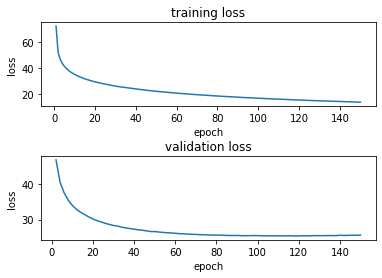

In [ ]:
train_epoch, train_loss = [], []
valid_epoch, valid_loss = [], []

for metrics in training_history:
  train_epoch.append(metrics["epoch"])
  train_loss.append(metrics["loss"])

for metrics in validation_history:
  valid_epoch.append(metrics["epoch"])
  valid_loss.append(metrics["loss"])

fig = plt.figure()
plt.subplots_adjust(hspace=0.6)

ax = fig.add_subplot(2, 1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('training loss')
ax.plot(train_epoch, train_loss)

ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('validation loss')
ax.plot(valid_epoch, valid_loss)
plt.show()

<img src=./images/train_and_valid.png>

## Translate some Sentences in the Training Dataset

　Try to translate only 10 sentences in the training data.

In [ ]:
#Check if it can translate sentences in train data.
for i, batch in enumerate(train_iterator):
  train_src = batch.src[:10]
  train_trg = batch.trg[:10]
  break

train_src, train_trg = jnp.asarray(train_src), jnp.asarray(train_trg)
translation, encoder_attention_list, decoder_attention_his, src_trg_attention_his = translator(train_src, state, model, config, return_attn=True)
for i, sent in enumerate(translation):
  print('src in train data: ', ' '.join(itos_de([id for id in train_src[i] if id not in config.special_idxes])))
  print('trg in train data: ', ' '.join(itos_en([id for id in train_trg[i] if id not in config.special_idxes])))
  print('model translation: ', ' '.join([token for token in list(sent) if token not in config.special_tokens]))
  print('------------------------------------')

src in train data:  ein junges mädchen <unk> die <unk> von <unk> .
trg in train data:  a young girl learns how electrical circuits work .
model translation:  a young girl <unk> the <unk> of her tent .
------------------------------------
src in train data:  ein kind hat sich verkleidet und hält einen <unk> in der hand .
trg in train data:  a child is dressed up in costume and holding a <unk> .
model translation:  a child is dressed up in costume and holding a <unk> . .
------------------------------------
src in train data:  ein mann und eine frau singen auf einer bühne .
trg in train data:  a man and woman are singing on a stage .
model translation:  a man and a woman are singing on a stage . .
------------------------------------
src in train data:  ein mann in einem gelben t-shirt hält einen großen camcorder .
trg in train data:  a man in a yellow t - shirt holds a large camcorder .
model translation:  a man in a yellow shirt holds a large camcorder . . .
---------------------------

The sample sentences were not at all translated, but the sentences in the training data seem to have been learned.

## Plot Attention Metrics

　Finally, implement a function to visualize the attention matrix. Using that function, for the first sentence of the sentence just translated, visualize the attention matrixes of the encoder final layer, the self-attention matrixes and src-trg matrixes of the decoder final layer at the end of translation for each heads. (Due to the specification of the Translator function, once <eos/> is output, inference isn't finished until the translation of the whole text is finished, so many <eos/>s are output.)

In [ ]:
def plot_attention(query_tokens: List[str],
                   key_tokens: List[str], 
                   attention: jnp.array
                   ):
    
    attention = jnp.squeeze(attention)
    assert attention.ndim == 3
    num_heads, q_seqlen, k_seqlen = attention.shape[0], attention.shape[1], attention.shape[2]
    fig = plt.figure(figsize=(20, 30))

    for i in range(num_heads):
      attention_per_head = attention[i, ...]
      ax = fig.add_subplot(int(num_heads/2), 2, i+1)
      cax = ax.matshow(attention_per_head, cmap='bone')
      ax.tick_params(labelsize=12)
      ax.set_xticklabels([''] + key_tokens, rotation=80)
      ax.set_yticklabels([''] + query_tokens)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
src, trg, translation_sent = train_src[0], train_trg[0], translation[0]
print('src in train data: ', ' '.join(itos_de([id for id in src if id not in config.special_idxes])))
print('trg in train data: ', ' '.join(itos_en([id for id in trg if id not in config.special_idxes])))
print('model translation: ', ' '.join([token for token in list(translation_sent) if token not in config.special_tokens]))

src in train data:  ein junges mädchen <unk> die <unk> von <unk> .
trg in train data:  a young girl learns how electrical circuits work .
model translation:  a young girl <unk> the <unk> of her tent .


<ipython-input-29-3564446ced06>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + key_tokens, rotation=80)
<ipython-input-29-3564446ced06>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + query_tokens)


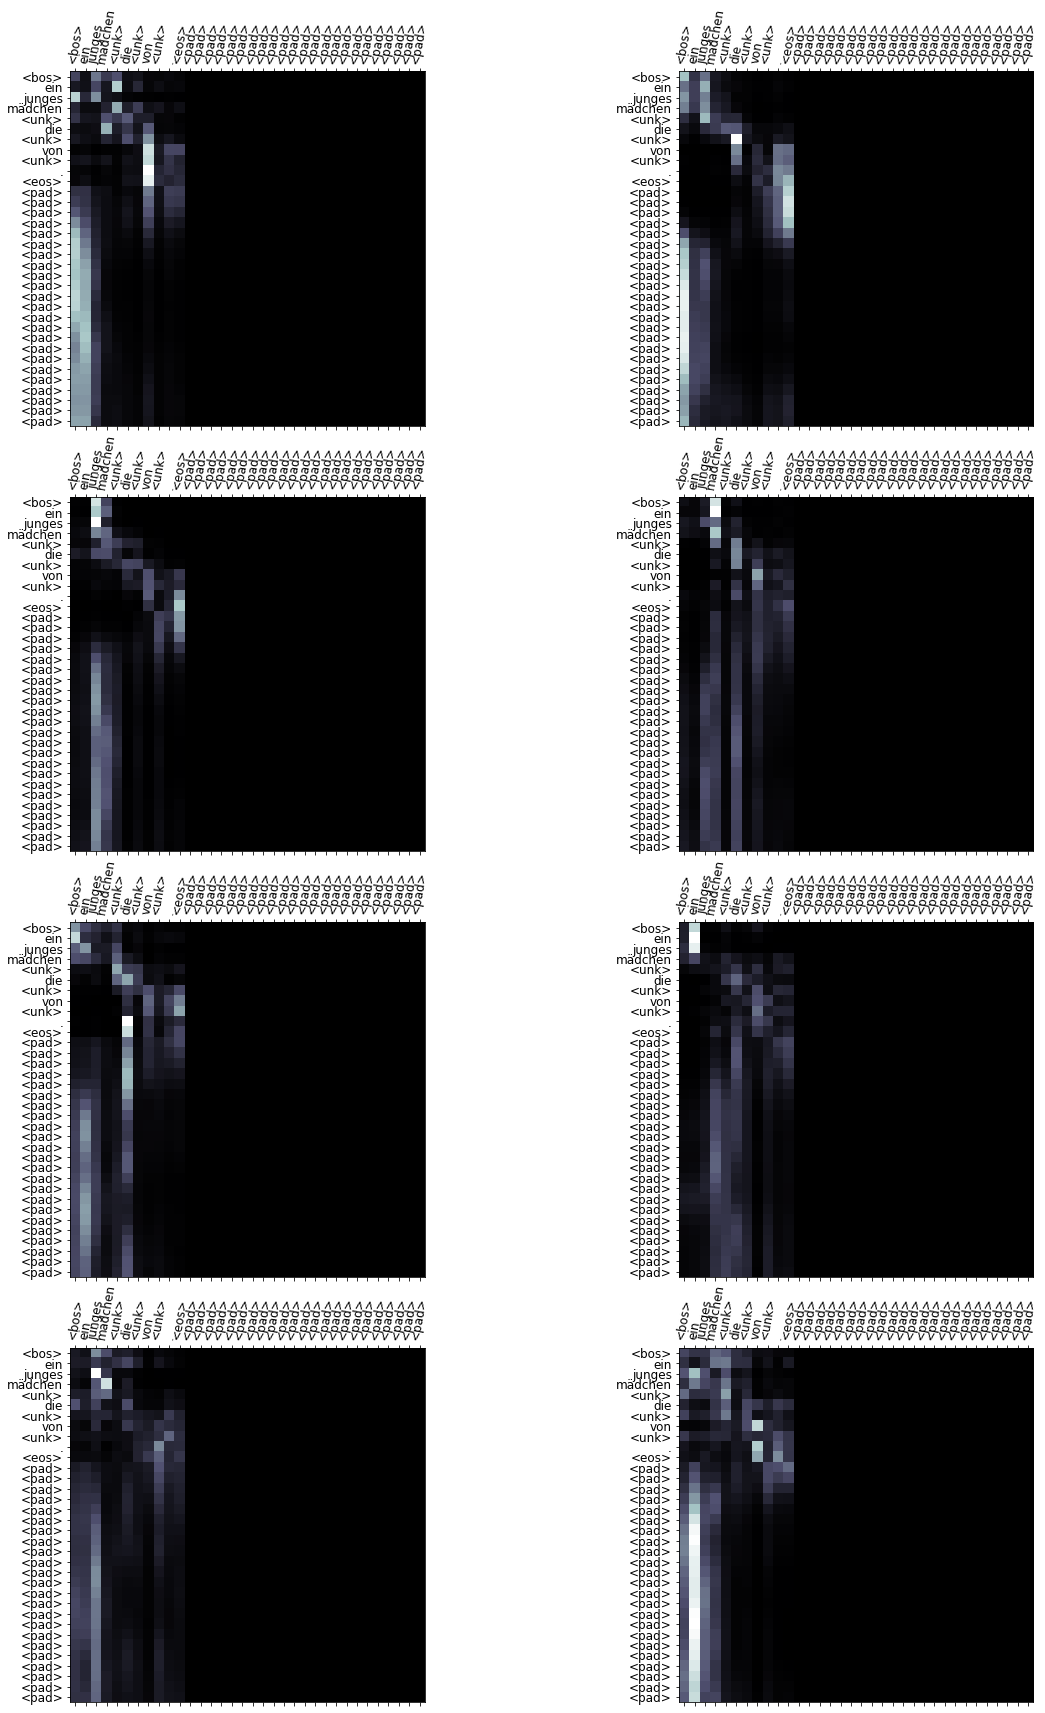

In [ ]:
plot_attention(itos_de(src), itos_de(src), encoder_attention_list[-1][0])

<ipython-input-29-3564446ced06>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + key_tokens, rotation=80)
<ipython-input-29-3564446ced06>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + query_tokens)


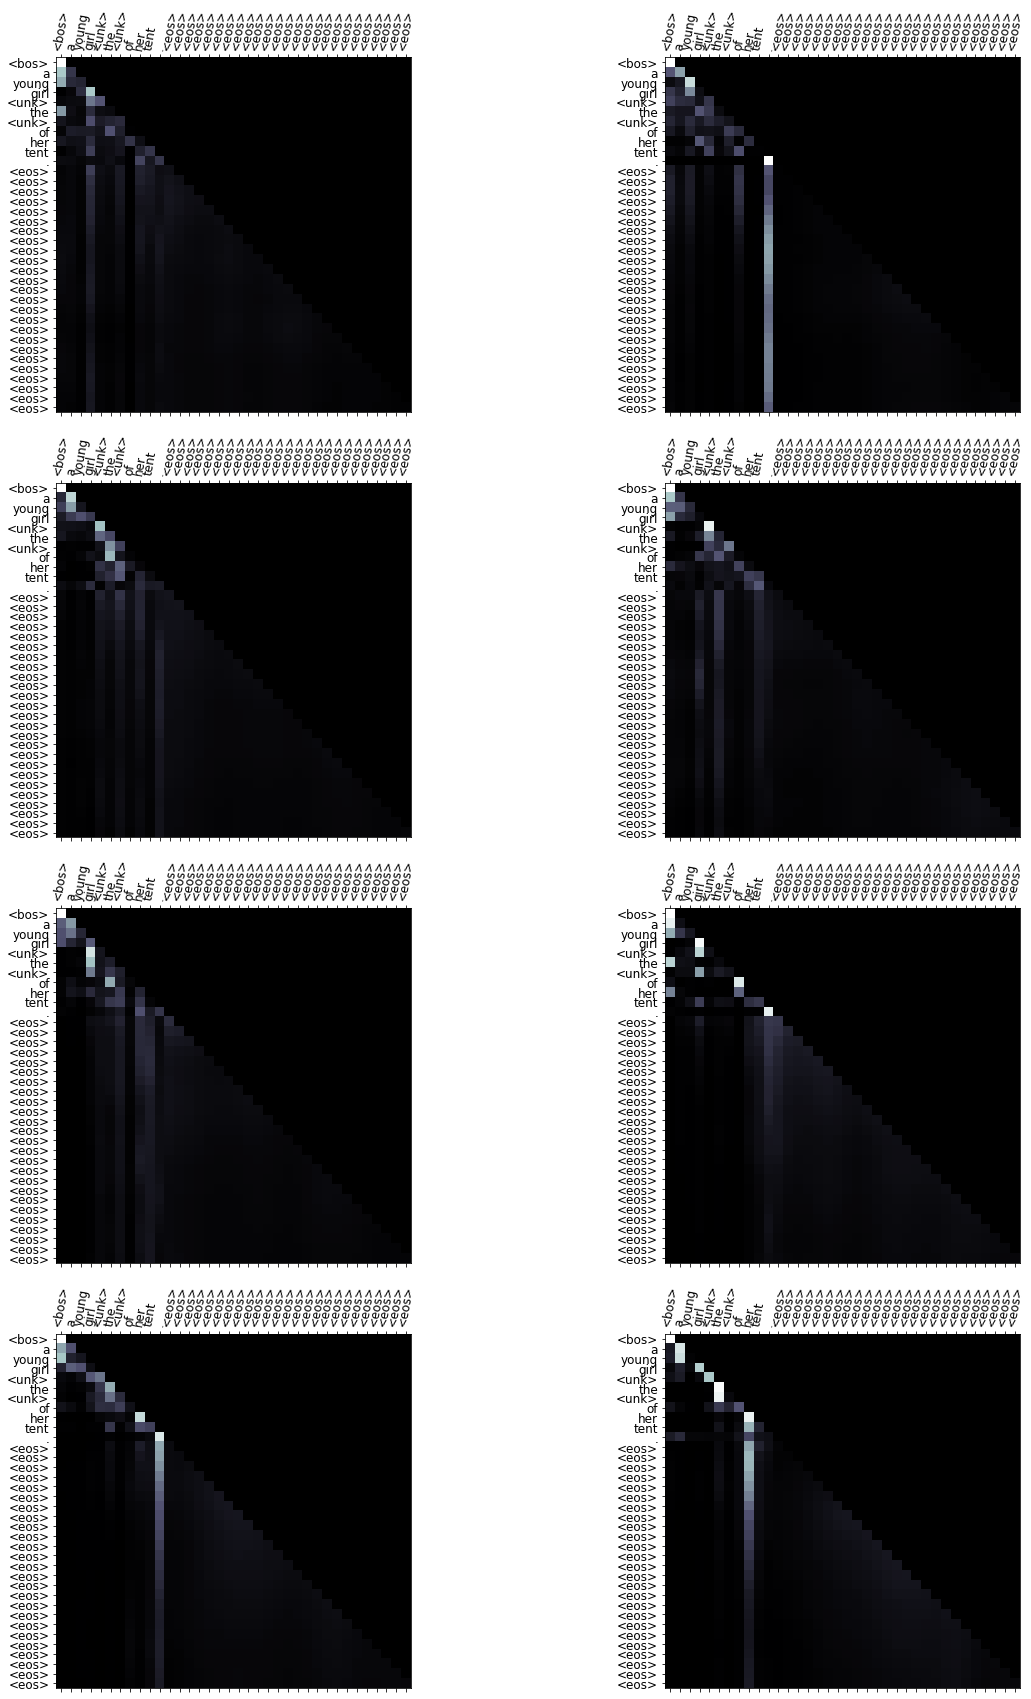

In [ ]:
plot_attention(translation_sent, translation_sent, decoder_attention_his[-1][-1][0])

<ipython-input-29-3564446ced06>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + key_tokens, rotation=80)
<ipython-input-29-3564446ced06>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + query_tokens)


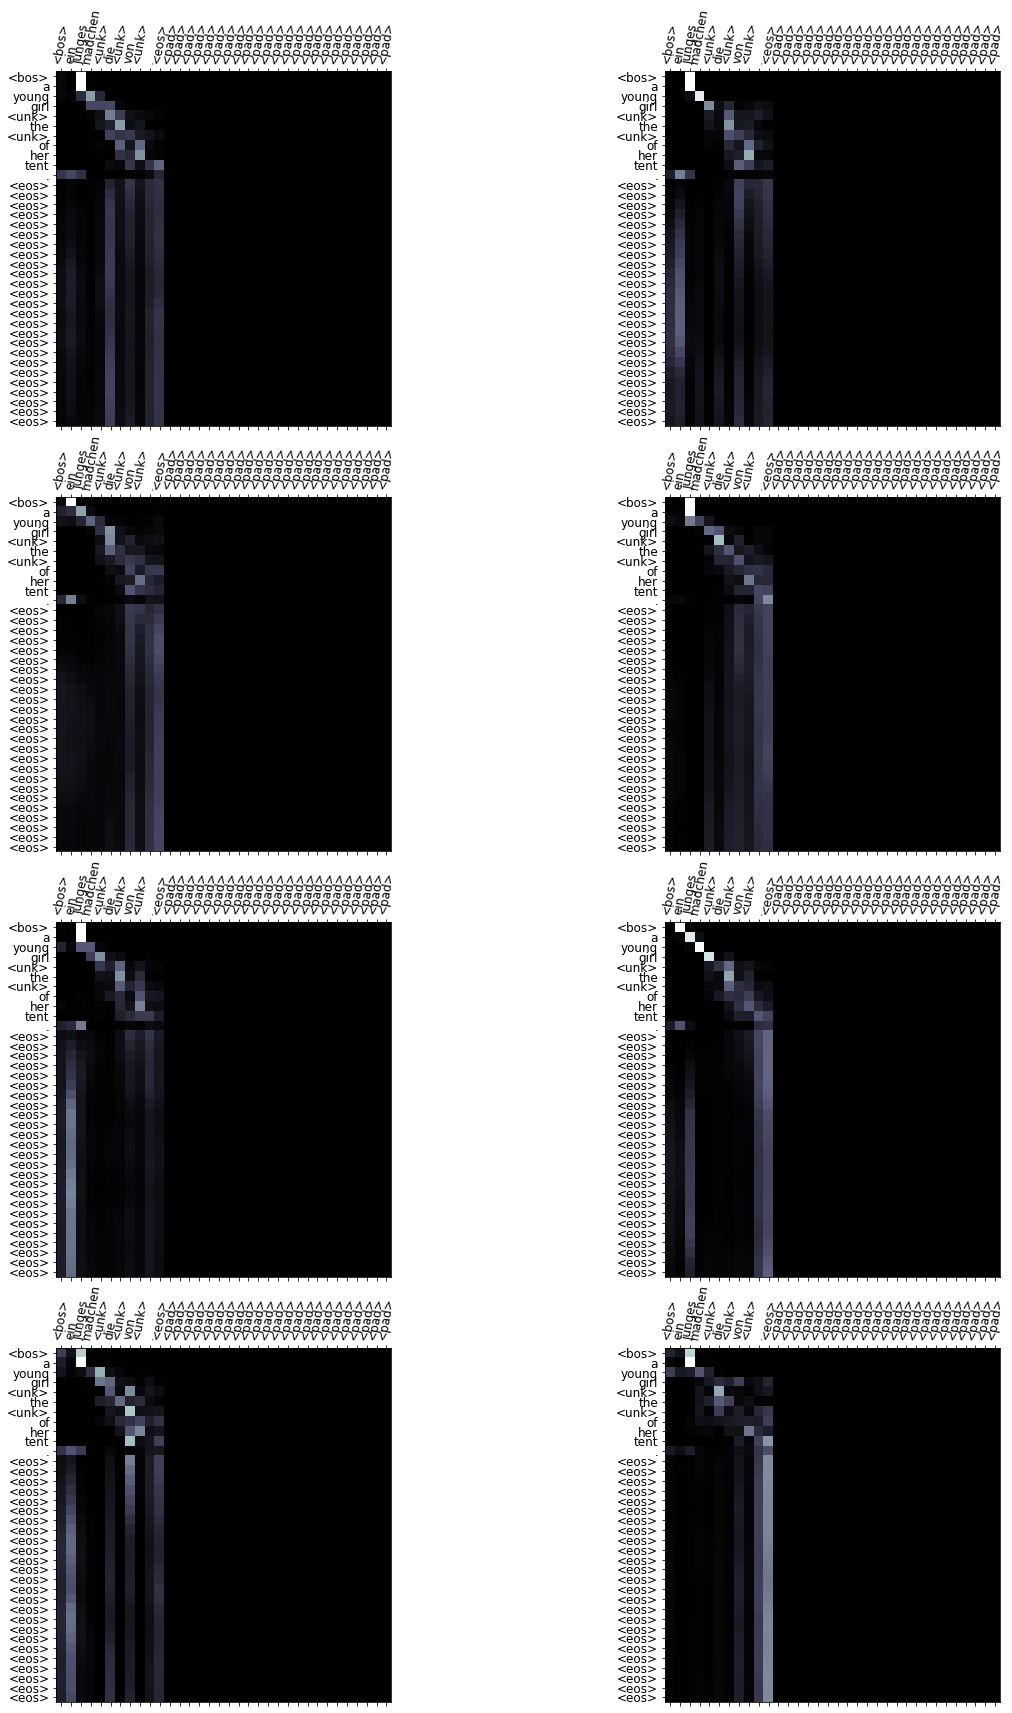

In [ ]:
plot_attention(translation_sent, itos_de(src),  src_trg_attention_his[-1][-1][0])

The attention matrixes for each head are shown. We can confirm that how each token is learned to be related to the other tokens. In the column direction, which is the key direction, the <pad/> is black, indicating that the attention is 0.

# Reference
- Paper

[1] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin (2017). Attention is All you Need. Advances in Neural Information Processing Systems, 2017-Decem, 5999–6009. 

- GitHub
1. https://github.com/bentrevett/pytorch-seq2seq
1. https://gist.github.com/enakai00/2371a25acb0bd7cd80ccd72c89364db9